# Eggplants production

This notebook will provide prediction for eggplants' prouduction in Jordan based on the season (summer, winter), region (irbid, ghor al safi), bad temperature count and bad humidity count. For further details please check the technical documentation.

In [72]:
# To measure the loading time
import time

start_time = time.time()

## Visualization

In [73]:
# Install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, IntegerType, FloatType, StringType, DateType

# In this colab we didn't use cluster we used single machine local[*].
# However, if we want change it to cluster, we can change it to master url 7077
spark =  SparkSession.builder.appName("SparkApp").master("local[*]").getOrCreate()

In [75]:
# Importing the tomatoes dataset
EggPlants = "EggPlants.csv"

# Using our own schema to define datatypes of the dataset features
Myschema = StructType([
StructField('Season', StringType(),True),
StructField('Crop', StringType(),True),
StructField('Station', StringType(),True),
StructField('Year', StringType(),True),
StructField('production', FloatType(),True)])

# Reading the data in df
df = spark.read.csv(EggPlants,header=True, schema=Myschema)

In [76]:
# Show the df
df.show()

+------+---------+------------+----+----------+
|Season|     Crop|     Station|Year|production|
+------+---------+------------+----+----------+
|Summer|Eggplants|       Irbid|2017|     575.5|
|Summer|Eggplants|Ghor al safi|2017|    3021.1|
|Winter|Eggplants|       Irbid|2017|     228.6|
|Winter|Eggplants|Ghor al safi|2017|    2306.4|
|Summer|Eggplants|       Irbid|2018|     668.7|
|Summer|Eggplants|Ghor al safi|2018|     762.4|
|Winter|Eggplants|       Irbid|2018|      76.4|
|Winter|Eggplants|Ghor al safi|2018|    3959.1|
|Summer|Eggplants|       Irbid|2019|     600.0|
|Summer|Eggplants|Ghor al safi|2019|     462.3|
|Winter|Eggplants|       Irbid|2019|       0.0|
|Winter|Eggplants|Ghor al safi|2019|    4194.1|
|Summer|Eggplants|       Irbid|2020|       0.0|
|Summer|Eggplants|Ghor al safi|2020|    1705.5|
|Winter|Eggplants|       Irbid|2020|       0.0|
|Winter|Eggplants|Ghor al safi|2020|    4724.1|
|Summer|Eggplants|       Irbid|2021|     978.8|
|Summer|Eggplants|Ghor al safi|2021|    

In [77]:
# Summary statistics
df.describe().show()

+-------+------+---------+------------+------------------+------------------+
|summary|Season|     Crop|     Station|              Year|        production|
+-------+------+---------+------------+------------------+------------------+
|  count|    20|       20|          20|                20|                20|
|   mean|  null|     null|        null|            2019.0|1734.5650058746337|
| stddev|  null|     null|        null|1.4509525002200603|1983.1816720430943|
|    min|Summer|Eggplants|Ghor al safi|              2017|               0.0|
|    max|Winter|Eggplants|       Irbid|              2021|            6737.3|
+-------+------+---------+------------+------------------+------------------+



In [78]:
# Plot production with season

import plotly.graph_objects as go
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Create a bar plot using Plotly
fig = go.Figure(data=[go.Bar(x=pandas_df['Season'], y=pandas_df['production'])])
fig.update_layout(
    xaxis_title='Season',
    yaxis_title='Production',
    title='Production by Season'
)
fig.show()


In [79]:
# Plot production with station

# Group the data by 'Station' and calculate the total production
grouped_df = pandas_df.groupby('Station')['production'].sum()

# Create a bar plot using Plotly
fig = go.Figure(data=[go.Bar(x=grouped_df.index, y=grouped_df.values)])
fig.update_layout(
    xaxis_title='Station',
    yaxis_title='Production',
    title='Production by Station'
)
fig.show()

In [80]:
# Plot production with year

# Group the data by 'Year' and calculate the total production
grouped_df = pandas_df.groupby('Year')['production'].sum()

# Create a line plot using Plotly
fig = go.Figure(data=go.Scatter(x=grouped_df.index, y=grouped_df.values, mode='lines'))
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Production',
    title='Production by Year'
)
fig.show()


In [81]:
# Plot production with all other features

import numpy as np

# Group the data by region, season, and year and calculate the total production
grouped_df = pandas_df.groupby(['Station', 'Season', 'Year'])['production'].sum().reset_index()

# Get unique values for regions, seasons, and years
regions = grouped_df['Station'].unique()
seasons = grouped_df['Season'].unique()
years = grouped_df['Year'].unique()

# Set the width of each bar
bar_width = 0.2

# Set the x-axis positions for each group
x = np.arange(len(years))

# Create the list to store the traces
traces = []

# Iterate over each region
for region in regions:
    for season in seasons:
        region_season_data = grouped_df[(grouped_df['Station'] == region) & (grouped_df['Season'] == season)]
        production_values = region_season_data['production']

        # Create a trace for the current region and season
        trace = go.Bar(
            x=x + (bar_width * (seasons.tolist().index(season))),
            y=production_values,
            name=f'{region} - {season}',
            width=bar_width
        )

        # Add the trace to the list
        traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title='Production Variation by Region, Season, and Year',
    xaxis=dict(
        tickmode='array',
        tickvals=x + bar_width * (len(seasons) - 1) / 2,
        ticktext=years.tolist(),
        title='Year'
    ),
    yaxis=dict(title='Total Production'),
    barmode='group'
)

# Create the figure using the traces and layout
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()


## Alignment with weather data

### With irbid weather

In [82]:
# Importing the dataset
WEATHER_IRBID = "i.csv"

# Read the CSV file and infer the schema
df_i = spark.read.csv(WEATHER_IRBID, header=True, inferSchema=True)

In [83]:
# Showing the df
df_i.show(10)

+----------+--------------------+-------------+------+
|      Date|Mean Air Temperature|Mean Humidity|Season|
+----------+--------------------+-------------+------+
|2017-01-01|                 8.5|         80.0|Winter|
|2017-01-02|                 8.0|         75.8|Winter|
|2017-01-03|         8.333333333|  84.33333333|Winter|
|2017-01-04|                 9.2|         66.0|Winter|
|2017-01-05|                12.0|         48.0|Winter|
|2017-01-06|                10.2|  45.65250079|Winter|
|2017-01-07|                10.2|         46.0|Winter|
|2017-01-08|                 7.8|         47.6|Winter|
|2017-01-09|                 6.8|         44.2|Winter|
|2017-01-10|                8.25|         40.5|Winter|
+----------+--------------------+-------------+------+
only showing top 10 rows



In [84]:
# Show the schema
df_i.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Mean Air Temperature: double (nullable = true)
 |-- Mean Humidity: double (nullable = true)
 |-- Season: string (nullable = true)



In [85]:
# Cast the Date column from string to date

from pyspark.sql.functions import col, to_date

# Convert the "Date" column to the "yyyy-MM-dd" format
df_i = df_i.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy"))

# Cast the "Date" column to Date type
df_i = df_i.withColumn("Date", col("Date").cast("date"))

In [86]:
# Check if the schema has changed
df_i.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Mean Air Temperature: double (nullable = true)
 |-- Mean Humidity: double (nullable = true)
 |-- Season: string (nullable = true)



In [87]:
# Summary statistics
df_i.describe().show()

+-------+--------------------+------------------+------+
|summary|Mean Air Temperature|     Mean Humidity|Season|
+-------+--------------------+------------------+------+
|  count|                2040|              2040|  2040|
|   mean|  19.127321428529402|56.774875153972516|  null|
| stddev|   7.076589847399458|13.324106132481635|  null|
|    min|                 2.0|       9.202668844|Summer|
|    max|                42.0|       97.37208413|Winter|
+-------+--------------------+------------------+------+



In [88]:
# Check nulls
from pyspark.sql.functions import *
col_null_cnt_df =  df_i.select([count(when(col(c).isNull(),c)).alias(c) for c in df_i.columns])
col_null_cnt_df.show()

+----+--------------------+-------------+------+
|Date|Mean Air Temperature|Mean Humidity|Season|
+----+--------------------+-------------+------+
|   0|                   0|            0|     0|
+----+--------------------+-------------+------+



In [89]:
# Engineer "bad temperature" feature

from pyspark.sql.functions import *

# Define the minimum and maximum thresholds for this crop
min = 10
max = 35

# Filter the rows where the temperature is below 10 or over 35
filtered_df = df_i.filter((col("Mean Air Temperature") < min) | (col("Mean Air Temperature") > max))

# Group by year and season, and count the number of days for each combination
result = filtered_df.groupBy(year(col("Date")).alias("Year"), col("Season")).agg(count("*").alias("Bad temperature count"))

# Replace null counts with 0
result = result.withColumn("Bad temperature count", coalesce(col("Bad temperature count"), lit(0)))

# Collect the unique combinations of year and season
year_season_combinations = df_i.select(year(col("Date")).alias("Year"), col("Season")).distinct()

# Join with the result to include combinations with count 0
result_with_zeros = year_season_combinations.join(result, ["Year", "Season"], "left_outer").fillna(0, subset=["Bad temperature count"])

# Collect the results into a list
result_list_2 = result_with_zeros.collect()

# Display the results
for row in result_list_2:
    print(f"Year: {row['Year']}, Season: {row['Season']}, Count: {row['Bad temperature count']}")



Year: 2020, Season: Summer, Count: 4
Year: 2019, Season: Summer, Count: 0
Year: 2021, Season: Summer, Count: 0
Year: 2022, Season: Summer, Count: 0
Year: 2019, Season: Winter, Count: 46
Year: 2022, Season: Winter, Count: 44
Year: 2023, Season: Winter, Count: 8
Year: 2021, Season: Winter, Count: 26
Year: 2018, Season: Summer, Count: 0
Year: 2017, Season: Winter, Count: 30
Year: 2017, Season: Summer, Count: 0
Year: 2020, Season: Winter, Count: 34
Year: 2018, Season: Winter, Count: 21


In [90]:
# Engineer "bad humidity" feature

# Define the minimum and maximum thresholds for this crop
min = 40
max = 80

# Filter the rows where the humidity is above 80 or under 40
filtered_df = df_i.filter((col("Mean Humidity") < min) | (col("Mean Humidity") > max))

# Group by year and season, and count the number of days for each combination
result = filtered_df.groupBy(year(col("Date")).alias("Year"), col("Season")).agg(count("*").alias("Bad humidity count"))

# Collect the unique combinations of year and season
year_season_combinations = df_i.select(year(col("Date")).alias("Year"), col("Season")).distinct()

# Join with the result to include combinations with count 0
result_with_zeros = year_season_combinations.join(result, ["Year", "Season"], "left_outer").fillna(0, subset=["Bad humidity count"])

# Collect the results into a list
result_list = result_with_zeros.collect()

# Display the results
for row in result_list:
    print(f"Year: {row['Year']}, Season: {row['Season']}, Count: {row['Bad humidity count']}")


Year: 2020, Season: Summer, Count: 14
Year: 2019, Season: Summer, Count: 9
Year: 2021, Season: Summer, Count: 2
Year: 2022, Season: Summer, Count: 14
Year: 2019, Season: Winter, Count: 27
Year: 2022, Season: Winter, Count: 35
Year: 2023, Season: Winter, Count: 0
Year: 2021, Season: Winter, Count: 26
Year: 2018, Season: Summer, Count: 6
Year: 2017, Season: Winter, Count: 58
Year: 2017, Season: Summer, Count: 25
Year: 2020, Season: Winter, Count: 27
Year: 2018, Season: Winter, Count: 24


In [91]:
# Create DataFrame from result_list_1
dft1 = spark.createDataFrame(result_list)

# Create DataFrame from result_list_2
dft2 = spark.createDataFrame(result_list_2)

# Join the DataFrames on "Year" and "Season"
df_i = dft1.join(dft2, ["Year", "Season"])

# Display the joined DataFrame
df_i.show()

+----+------+------------------+---------------------+
|Year|Season|Bad humidity count|Bad temperature count|
+----+------+------------------+---------------------+
|2017|Summer|                25|                    0|
|2017|Winter|                58|                   30|
|2018|Summer|                 6|                    0|
|2018|Winter|                24|                   21|
|2019|Summer|                 9|                    0|
|2019|Winter|                27|                   46|
|2020|Summer|                14|                    4|
|2020|Winter|                27|                   34|
|2021|Summer|                 2|                    0|
|2021|Winter|                26|                   26|
|2022|Summer|                14|                    0|
|2022|Winter|                35|                   44|
|2023|Winter|                 0|                    8|
+----+------+------------------+---------------------+



In [92]:
# Plot the years with the engineered features

import plotly.graph_objects as go
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pd = df_i.toPandas()

# Create traces for each feature
humidity_trace = go.Bar(x=df_pd['Year'], y=df_pd['Bad humidity count'], name='Bad Humidity Count')
temperature_trace = go.Bar(x=df_pd['Year'], y=df_pd['Bad temperature count'], name='Bad Temperature Count')

# Create the layout
layout = go.Layout(
    title='Bad Weather Counts by Year',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Count'),
    barmode='group'
)

# Create the figure and add traces
fig = go.Figure(data=[humidity_trace, temperature_trace], layout=layout)

# Show the figure
fig.show()

In [93]:
# Plot the years with the engineered features

import plotly.graph_objects as go
import pyspark.sql.functions as F

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pd = df_i.toPandas()

# Create a line plot for Bad humidity count
fig_humidity = go.Figure(data=go.Scatter(x=df_pd['Year'].astype(str) + ' - ' + df_pd['Season'],
                                        y=df_pd['Bad humidity count'],
                                        mode='lines',
                                        name='Bad humidity count'))

# Update the layout for Bad humidity count
fig_humidity.update_layout(
    title='Bad Humidity Count by Year and Season',
    xaxis_title='Year - Season',
    yaxis_title='Count'
)

# Create a line plot for Bad temperature count
fig_temperature = go.Figure(data=go.Scatter(x=df_pd['Year'].astype(str) + ' - ' + df_pd['Season'],
                                           y=df_pd['Bad temperature count'],
                                           mode='lines',
                                           name='Bad temperature count'))

# Update the layout for Bad temperature count
fig_temperature.update_layout(
    title='Bad Temperature Count by Year and Season',
    xaxis_title='Year - Season',
    yaxis_title='Count'
)

# Show the plots
fig_humidity.show()
fig_temperature.show()


### With Ghor weather

In [94]:
# Importing the dataset
WEATHER_GHOR = "g.csv"

# Read the CSV file and infer the schema
df_g = spark.read.csv(WEATHER_GHOR, header=True, inferSchema=True)

In [95]:
# Showing the df
df_g.show(10)

+----------+--------------------+-------------+------+
|      Date|Mean Air Temperature|Mean Humidity|Season|
+----------+--------------------+-------------+------+
|2017-01-08|                21.0|         37.0|Winter|
|2017-01-09|                16.5|         41.0|Winter|
|2017-01-10|                15.0|         54.0|Winter|
|2017-01-11|                13.5|         63.0|Winter|
|2017-01-12|                16.0|         50.5|Winter|
|2017-01-13|                18.5|         51.5|Winter|
|2017-01-14|                19.5|         55.0|Winter|
|2017-01-15|                14.5|         68.0|Winter|
|2017-01-16|                18.0|         55.5|Winter|
|2017-01-17|                16.5|         62.0|Winter|
+----------+--------------------+-------------+------+
only showing top 10 rows



In [96]:
# Show the schema
df_g.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Mean Air Temperature: double (nullable = true)
 |-- Mean Humidity: double (nullable = true)
 |-- Season: string (nullable = true)



In [97]:
# Cast the Date column from string to date

from pyspark.sql.functions import col, to_date

# Convert the "Date" column to the "yyyy-MM-dd" format
df_g = df_g.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy"))

# Cast the "Date" column to Date type
df_g = df_g.withColumn("Date", col("Date").cast("date"))

In [98]:
# Check if the schema has changed
df_g.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Mean Air Temperature: double (nullable = true)
 |-- Mean Humidity: double (nullable = true)
 |-- Season: string (nullable = true)



In [99]:
# Summary statistics
df_g.describe().show()

+-------+--------------------+------------------+------+
|summary|Mean Air Temperature|     Mean Humidity|Season|
+-------+--------------------+------------------+------+
|  count|                2129|              2129|  2129|
|   mean|  27.256341564274344| 45.47591768469415|  null|
| stddev|   7.434613986702827|10.881178569975193|  null|
|    min|                 9.0|      -4.095747666|Summer|
|    max|                46.5|              83.0|Winter|
+-------+--------------------+------------------+------+



In [100]:
# Check nulls
from pyspark.sql.functions import *
col_null_cnt_df =  df_g.select([count(when(col(c).isNull(),c)).alias(c) for c in df_g.columns])
col_null_cnt_df.show()

+----+--------------------+-------------+------+
|Date|Mean Air Temperature|Mean Humidity|Season|
+----+--------------------+-------------+------+
|   0|                   0|            0|     0|
+----+--------------------+-------------+------+



In [101]:
# Engineer "bad temperature" feature

from pyspark.sql.functions import *

# Define the minimum and maximum thresholds for this crop
min = 10
max = 35

# Filter the rows where the temperature is below 10 or over 35
filtered_df = df_g.filter((col("Mean Air Temperature") < min) | (col("Mean Air Temperature") > max))

# Group by year and season, and count the number of days for each combination
result = filtered_df.groupBy(year(col("Date")).alias("Year"), col("Season")).agg(count("*").alias("Bad temperature count"))

# Replace null counts with 0
result = result.withColumn("Bad temperature count", coalesce(col("Bad temperature count"), lit(0)))

# Collect the unique combinations of year and season
year_season_combinations = df_g.select(year(col("Date")).alias("Year"), col("Season")).distinct()

# Join with the result to include combinations with count 0
result_with_zeros = year_season_combinations.join(result, ["Year", "Season"], "left_outer").fillna(0, subset=["Bad temperature count"])

# Collect the results into a list
result_list_2 = result_with_zeros.collect()

# Display the results
for row in result_list_2:
    print(f"Year: {row['Year']}, Season: {row['Season']}, Count: {row['Bad temperature count']}")

Year: 2020, Season: Summer, Count: 44
Year: 2019, Season: Summer, Count: 52
Year: 2021, Season: Summer, Count: 53
Year: 2022, Season: Summer, Count: 101
Year: 2019, Season: Winter, Count: 0
Year: 2022, Season: Winter, Count: 0
Year: 2023, Season: Winter, Count: 0
Year: 2021, Season: Winter, Count: 0
Year: 2018, Season: Summer, Count: 50
Year: 2017, Season: Winter, Count: 0
Year: 2017, Season: Summer, Count: 63
Year: 2020, Season: Winter, Count: 1
Year: 2018, Season: Winter, Count: 0


In [102]:
# Engineer "bad humidity" feature

# Define the minimum and maximum thresholds for this crop
min = 40
max = 80

# Filter the rows where the humidity is above 80 or under 40
filtered_df = df_g.filter((col("Mean Humidity") < 40) | (col("Mean Humidity") > 80))

# Group by year and season, and count the number of days for each combination
result = filtered_df.groupBy(year(col("Date")).alias("Year"), col("Season")).agg(count("*").alias("Bad humidity count"))

# Collect the unique combinations of year and season
year_season_combinations = df_g.select(year(col("Date")).alias("Year"), col("Season")).distinct()

# Join with the result to include combinations with count 0
result_with_zeros = year_season_combinations.join(result, ["Year", "Season"], "left_outer").fillna(0, subset=["Bad humidity count"])

# Collect the results into a list
result_list = result_with_zeros.collect()

# Display the results
for row in result_list:
    print(f"Year: {row['Year']}, Season: {row['Season']}, Count: {row['Bad humidity count']}")


Year: 2020, Season: Summer, Count: 116
Year: 2019, Season: Summer, Count: 115
Year: 2021, Season: Summer, Count: 125
Year: 2022, Season: Summer, Count: 162
Year: 2019, Season: Winter, Count: 3
Year: 2022, Season: Winter, Count: 2
Year: 2023, Season: Winter, Count: 1
Year: 2021, Season: Winter, Count: 2
Year: 2018, Season: Summer, Count: 141
Year: 2017, Season: Winter, Count: 6
Year: 2017, Season: Summer, Count: 40
Year: 2020, Season: Winter, Count: 5
Year: 2018, Season: Winter, Count: 2


In [103]:
# Create DataFrame from result_list_1
dft1 = spark.createDataFrame(result_list)

# Create DataFrame from result_list_2
dft2 = spark.createDataFrame(result_list_2)

# Join the DataFrames on "Year" and "Season"
df_g = dft1.join(dft2, ["Year", "Season"])

# Display the joined DataFrame
df_g.show()

+----+------+------------------+---------------------+
|Year|Season|Bad humidity count|Bad temperature count|
+----+------+------------------+---------------------+
|2017|Summer|                40|                   63|
|2017|Winter|                 6|                    0|
|2018|Summer|               141|                   50|
|2018|Winter|                 2|                    0|
|2019|Summer|               115|                   52|
|2019|Winter|                 3|                    0|
|2020|Summer|               116|                   44|
|2020|Winter|                 5|                    1|
|2021|Summer|               125|                   53|
|2021|Winter|                 2|                    0|
|2022|Summer|               162|                  101|
|2022|Winter|                 2|                    0|
|2023|Winter|                 1|                    0|
+----+------+------------------+---------------------+



In [104]:
# Plot the years with the engineered features

import plotly.graph_objects as go
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pd = df_g.toPandas()

# Create traces for each feature
humidity_trace = go.Bar(x=df_pd['Year'], y=df_pd['Bad humidity count'], name='Bad Humidity Count')
temperature_trace = go.Bar(x=df_pd['Year'], y=df_pd['Bad temperature count'], name='Bad Temperature Count')

# Create the layout
layout = go.Layout(
    title='Bad Weather Counts by Year',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Count'),
    barmode='group'
)

# Create the figure and add traces
fig = go.Figure(data=[humidity_trace, temperature_trace], layout=layout)

# Show the figure
fig.show()

In [105]:
# Plot the years with the engineered features

import plotly.graph_objects as go
import pyspark.sql.functions as F

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pd = df_g.toPandas()

# Create a line plot for Bad humidity count
fig_humidity = go.Figure(data=go.Scatter(x=df_pd['Year'].astype(str) + ' - ' + df_pd['Season'],
                                        y=df_pd['Bad humidity count'],
                                        mode='lines',
                                        name='Bad humidity count'))

# Update the layout for Bad humidity count
fig_humidity.update_layout(
    title='Bad Humidity Count by Year and Season',
    xaxis_title='Year - Season',
    yaxis_title='Count'
)

# Create a line plot for Bad temperature count
fig_temperature = go.Figure(data=go.Scatter(x=df_pd['Year'].astype(str) + ' - ' + df_pd['Season'],
                                           y=df_pd['Bad temperature count'],
                                           mode='lines',
                                           name='Bad temperature count'))

# Update the layout for Bad temperature count
fig_temperature.update_layout(
    title='Bad Temperature Count by Year and Season',
    xaxis_title='Year - Season',
    yaxis_title='Count'
)

# Show the plots
fig_humidity.show()
fig_temperature.show()


### Merging irbid and ghor

In [106]:
# Adding station column to irbid weather

from pyspark.sql.functions import lit

# Add 'Station' column with value 'Irbid'
df_i = df_i.withColumn('Station', lit('Irbid'))

# Show the updated DataFrame
df_i.show()

+----+------+------------------+---------------------+-------+
|Year|Season|Bad humidity count|Bad temperature count|Station|
+----+------+------------------+---------------------+-------+
|2017|Summer|                25|                    0|  Irbid|
|2017|Winter|                58|                   30|  Irbid|
|2018|Summer|                 6|                    0|  Irbid|
|2018|Winter|                24|                   21|  Irbid|
|2019|Summer|                 9|                    0|  Irbid|
|2019|Winter|                27|                   46|  Irbid|
|2020|Summer|                14|                    4|  Irbid|
|2020|Winter|                27|                   34|  Irbid|
|2021|Summer|                 2|                    0|  Irbid|
|2021|Winter|                26|                   26|  Irbid|
|2022|Summer|                14|                    0|  Irbid|
|2022|Winter|                35|                   44|  Irbid|
|2023|Winter|                 0|                    8| 

In [107]:
# Adding station column to ghor weather

df_g = df_g.withColumn('Station', lit('Ghor al safi'))

# Show the updated DataFrame
df_g.show()

+----+------+------------------+---------------------+------------+
|Year|Season|Bad humidity count|Bad temperature count|     Station|
+----+------+------------------+---------------------+------------+
|2017|Summer|                40|                   63|Ghor al safi|
|2017|Winter|                 6|                    0|Ghor al safi|
|2018|Summer|               141|                   50|Ghor al safi|
|2018|Winter|                 2|                    0|Ghor al safi|
|2019|Summer|               115|                   52|Ghor al safi|
|2019|Winter|                 3|                    0|Ghor al safi|
|2020|Summer|               116|                   44|Ghor al safi|
|2020|Winter|                 5|                    1|Ghor al safi|
|2021|Summer|               125|                   53|Ghor al safi|
|2021|Winter|                 2|                    0|Ghor al safi|
|2022|Summer|               162|                  101|Ghor al safi|
|2022|Winter|                 2|                

In [108]:
# Merge the rows of the two DataFrames
merged_df = df_i.union(df_g)

# Show the merged DataFrame
merged_df.show(50)

+----+------+------------------+---------------------+------------+
|Year|Season|Bad humidity count|Bad temperature count|     Station|
+----+------+------------------+---------------------+------------+
|2017|Summer|                25|                    0|       Irbid|
|2017|Winter|                58|                   30|       Irbid|
|2018|Summer|                 6|                    0|       Irbid|
|2018|Winter|                24|                   21|       Irbid|
|2019|Summer|                 9|                    0|       Irbid|
|2019|Winter|                27|                   46|       Irbid|
|2020|Summer|                14|                    4|       Irbid|
|2020|Winter|                27|                   34|       Irbid|
|2021|Summer|                 2|                    0|       Irbid|
|2021|Winter|                26|                   26|       Irbid|
|2022|Summer|                14|                    0|       Irbid|
|2022|Winter|                35|                

### Merge weather with production

In [109]:
final_df = df.join(merged_df, ["Year", "Season", "Station"], "inner")

# Show the merged DataFrame
final_df.show()

+----+------+------------+---------+----------+------------------+---------------------+
|Year|Season|     Station|     Crop|production|Bad humidity count|Bad temperature count|
+----+------+------------+---------+----------+------------------+---------------------+
|2017|Summer|       Irbid|Eggplants|     575.5|                25|                    0|
|2017|Winter|       Irbid|Eggplants|     228.6|                58|                   30|
|2018|Summer|       Irbid|Eggplants|     668.7|                 6|                    0|
|2018|Winter|       Irbid|Eggplants|      76.4|                24|                   21|
|2019|Summer|       Irbid|Eggplants|     600.0|                 9|                    0|
|2019|Winter|       Irbid|Eggplants|       0.0|                27|                   46|
|2020|Summer|       Irbid|Eggplants|       0.0|                14|                    4|
|2020|Winter|       Irbid|Eggplants|       0.0|                27|                   34|
|2021|Summer|       I

## Create model

In [110]:
# Encoding the two categorical features: season and station

from pyspark.ml.feature import StringIndexer

# Create StringIndexer for Season
season_indexer = StringIndexer(inputCol="Season", outputCol="Season_Encoded")
season_model = season_indexer.fit(final_df)
final_df = season_model.transform(final_df)

# Create StringIndexer for Station
station_indexer = StringIndexer(inputCol="Station", outputCol="Station_Encoded")
station_model = station_indexer.fit(final_df)
final_df = station_model.transform(final_df)

# Display the transformed DataFrame
final_df.show()

+----+------+------------+---------+----------+------------------+---------------------+--------------+---------------+
|Year|Season|     Station|     Crop|production|Bad humidity count|Bad temperature count|Season_Encoded|Station_Encoded|
+----+------+------------+---------+----------+------------------+---------------------+--------------+---------------+
|2017|Summer|       Irbid|Eggplants|     575.5|                25|                    0|           0.0|            1.0|
|2017|Winter|       Irbid|Eggplants|     228.6|                58|                   30|           1.0|            1.0|
|2018|Summer|       Irbid|Eggplants|     668.7|                 6|                    0|           0.0|            1.0|
|2018|Winter|       Irbid|Eggplants|      76.4|                24|                   21|           1.0|            1.0|
|2019|Summer|       Irbid|Eggplants|     600.0|                 9|                    0|           0.0|            1.0|
|2019|Winter|       Irbid|Eggplants|    

In [111]:
# Drop the two categorical columns from the DataFrame
final_df = final_df.drop("Station")
final_df = final_df.drop("Season")
final_df = final_df.drop("Crop")

In [112]:
# Scaling in pandas
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = final_df.toPandas()

# Perform feature scaling using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pandas_df)

# Create a new DataFrame with scaled features
pandas_df = pd.DataFrame(scaled_features, columns=pandas_df.columns)

In [113]:
# Convert back to pyspark
pyspark_df = spark.createDataFrame(pandas_df)
pyspark_df.show()

+-------------------+--------------------+--------------------+---------------------+--------------+---------------+
|               Year|          production|  Bad humidity count|Bad temperature count|Season_Encoded|Station_Encoded|
+-------------------+--------------------+--------------------+---------------------+--------------+---------------+
| -1.414213562373095| -0.5996301909455047|-0.30146133922042045|  -0.9371361521030721|          -1.0|            1.0|
| -1.414213562373095| -0.7790952843827595|   0.427346294059717|   0.3889999121937281|           1.0|            1.0|
|-0.7071067811865475| -0.5514141367703085| -0.7210778553514087|  -0.9371361521030721|          -1.0|            1.0|
|-0.7071067811865475| -0.8578343692004632|-0.32354641901678827| -0.00884090709531197|           1.0|            1.0|
|                0.0| -0.5869553714973246| -0.6548226159623053|  -0.9371361521030721|          -1.0|            1.0|
|                0.0| -0.8973591130854104| -0.2572911796276849| 

In [114]:
# Get feature importance for the features

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# Create a vector assembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=["Bad humidity count", "Bad temperature count", "Season_Encoded", "Station_Encoded"],
                            outputCol="features")

# Apply the vector assembler to transform the DataFrame
assembled_df = assembler.transform(pyspark_df)

# Create a random forest regressor model
rf = RandomForestRegressor(labelCol="production", featuresCol="features")

# Fit the model to the data
model = rf.fit(assembled_df)

# Get the feature importances
importances = model.featureImportances

# Print the feature importances
for idx, feature in enumerate(assembler.getInputCols()):
    print(f"Feature: {feature}, Importance: {importances[idx]}")


Feature: Bad humidity count, Importance: 0.5887153173081531
Feature: Bad temperature count, Importance: 0.10971569032000292
Feature: Season_Encoded, Importance: 0.06909176450736004
Feature: Station_Encoded, Importance: 0.2324772278644839


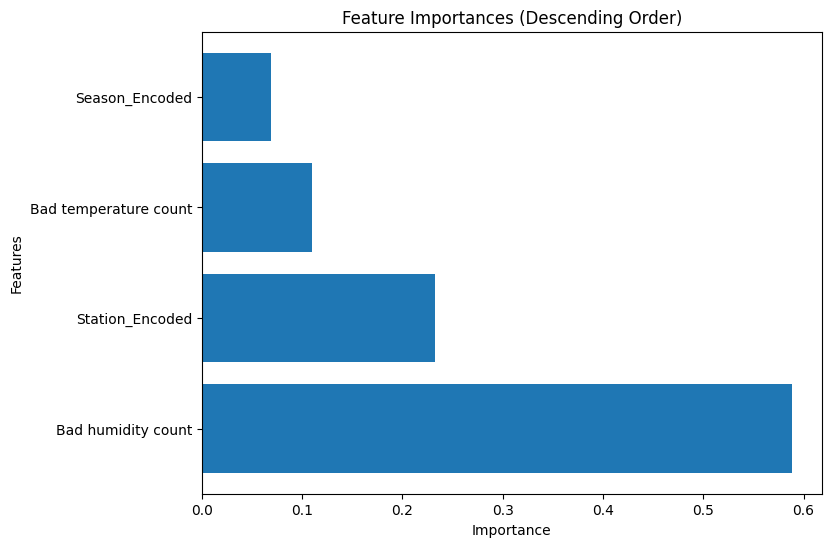

In [115]:
# Plot the feature importance

import matplotlib.pyplot as plt

# Retrieve feature importances
importances = model.featureImportances.toArray()

# Retrieve feature names
feature_names = assembler.getInputCols()

# Sort feature importances and feature names in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create a bar plot of feature importances
plt.figure(figsize=(8, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances (Descending Order)')
plt.show()


In [116]:
# Linear regression to predict the production without data splitting

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Create a VectorAssembler to combine the feature columns into a single vector column
assembler = VectorAssembler(inputCols=["Bad humidity count", "Bad temperature count", "Season_Encoded", "Station_Encoded"], outputCol="features")

# Transform the DataFrame to include the vectorized features
data = assembler.transform(pyspark_df)

# Create a LinearRegression model
lr = LinearRegression(featuresCol="features", labelCol="production")

# Fit the model to the entire data
lr_model = lr.fit(data)

# Make predictions on the data
predictions = lr_model.transform(data)

# Print the model coefficients
coefficients = lr_model.coefficients
intercept = lr_model.intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Evaluate the model
evaluator = lr_model.evaluate(data)
r2 = evaluator.r2
rmse = evaluator.rootMeanSquaredError

# Print evaluation metrics
print("R-squared:", r2)
print("Root Mean Squared Error:", rmse)


Coefficients: [-0.38960292228228255,-0.1159260571945367,0.04712664341476469,-0.9066543646232293]
Intercept: 9.303729705957055e-17
R-squared: 0.7692274225027796
Root Mean Squared Error: 0.4803879447875648


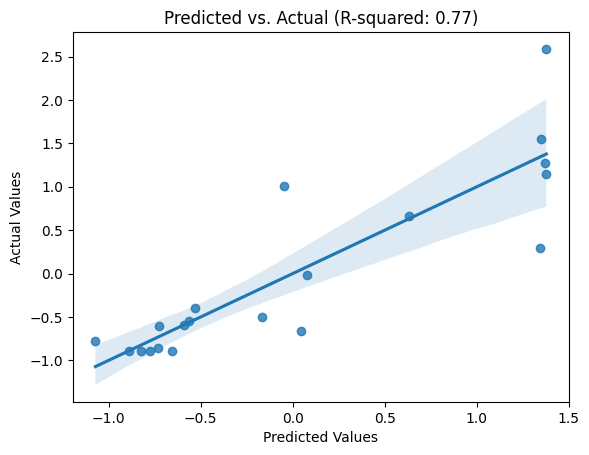

In [117]:
# Plot the result of the model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to pandas DataFrame
predictions_pd = predictions.select("prediction").toPandas()
actuals_pd = predictions.select("production").toPandas()

# Calculate R-squared
evaluator = lr_model.evaluate(data)
r2 = evaluator.r2

# Plot the predicted values and actual values
sns.regplot(x=predictions_pd["prediction"], y=actuals_pd["production"])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title(f'Predicted vs. Actual (R-squared: {r2:.2f})')
plt.show()

## Further visualization

In [118]:
import plotly.express as px
import pandas as pd

f = ["Bad humidity count", "Bad temperature count", "Season_Encoded", "Station_Encoded"]
df_pd = final_df.toPandas()

for feature in f:

    # Plot the variables
    fig = px.scatter(df_pd, x=feature, y="production")

    fig.update_layout(
        title="Production vs. " + feature,
        xaxis_title=feature,
        yaxis_title="Production"
    )

    fig.show()

## Future predictions

In [119]:
# Choose rows where production is not available to predict it

from pyspark.sql.functions import col

filtered_df = merged_df.filter(col("Year") > 2021)

filtered_df.show()

+----+------+------------------+---------------------+------------+
|Year|Season|Bad humidity count|Bad temperature count|     Station|
+----+------+------------------+---------------------+------------+
|2022|Summer|                14|                    0|       Irbid|
|2022|Winter|                35|                   44|       Irbid|
|2023|Winter|                 0|                    8|       Irbid|
|2022|Summer|               162|                  101|Ghor al safi|
|2022|Winter|                 2|                    0|Ghor al safi|
|2023|Winter|                 1|                    0|Ghor al safi|
+----+------+------------------+---------------------+------------+



In [120]:
# Encoding the two categorical features: season and station

from pyspark.ml.feature import StringIndexer

# Create StringIndexer for Season
season_indexer = StringIndexer(inputCol="Season", outputCol="Season_Encoded")
season_model = season_indexer.fit(filtered_df)
filtered_df = season_model.transform(filtered_df)

# Create StringIndexer for Station
station_indexer = StringIndexer(inputCol="Station", outputCol="Station_Encoded")
station_model = station_indexer.fit(filtered_df)
filtered_df = station_model.transform(filtered_df)

# Display the transformed DataFrame
filtered_df.show()

+----+------+------------------+---------------------+------------+--------------+---------------+
|Year|Season|Bad humidity count|Bad temperature count|     Station|Season_Encoded|Station_Encoded|
+----+------+------------------+---------------------+------------+--------------+---------------+
|2022|Summer|                14|                    0|       Irbid|           1.0|            1.0|
|2022|Winter|                35|                   44|       Irbid|           0.0|            1.0|
|2023|Winter|                 0|                    8|       Irbid|           0.0|            1.0|
|2022|Summer|               162|                  101|Ghor al safi|           1.0|            0.0|
|2022|Winter|                 2|                    0|Ghor al safi|           0.0|            0.0|
|2023|Winter|                 1|                    0|Ghor al safi|           0.0|            0.0|
+----+------+------------------+---------------------+------------+--------------+---------------+



In [121]:
# Drop the two categorical columns from the DataFrame
filtered_df = filtered_df.drop("Station")
filtered_df = filtered_df.drop("Season")
filtered_df = filtered_df.drop("Crop")

In [122]:
# Scaling in pandas
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = filtered_df.toPandas()

# Perform feature scaling using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pandas_df)

# Create a new DataFrame with scaled features
pandas_df = pd.DataFrame(scaled_features, columns=pandas_df.columns)

In [123]:
# Convert back to pyspark
pyspark_df_test = spark.createDataFrame(pandas_df)
pyspark_df_test.show()

+-------------------+--------------------+---------------------+-------------------+---------------+
|               Year|  Bad humidity count|Bad temperature count|     Season_Encoded|Station_Encoded|
+-------------------+--------------------+---------------------+-------------------+---------------+
|-0.7071067811863867| -0.3749279054112341|  -0.6856300456892042| 1.4142135623730951|            1.0|
|-0.7071067811863867|-0.01153624324342255|   0.4974178762843246|-0.7071067811865475|            1.0|
|  1.414213562373256| -0.6171890135231085|  -0.4705304235121989|-0.7071067811865475|            1.0|
|-0.7071067811863867|   2.186118094628581|   2.0300026842954866| 1.4142135623730951|           -1.0|
|-0.7071067811863867| -0.5825802837928408|  -0.6856300456892042|-0.7071067811865475|           -1.0|
|  1.414213562373256| -0.5998846486579746|  -0.6856300456892042|-0.7071067811865475|           -1.0|
+-------------------+--------------------+---------------------+-------------------+-------

In [124]:
# Transform data
new_data_transformed = assembler.transform(pyspark_df_test)

# Make predictions using the linear regression model
predictions = lr_model.transform(new_data_transformed)

# Show the predicted values
predictions.show()

+-------------------+--------------------+---------------------+-------------------+---------------+--------------------+--------------------+
|               Year|  Bad humidity count|Bad temperature count|     Season_Encoded|Station_Encoded|            features|          prediction|
+-------------------+--------------------+---------------------+-------------------+---------------+--------------------+--------------------+
|-0.7071067811863867| -0.3749279054112341|  -0.6856300456892042| 1.4142135623730951|            1.0|[-0.3749279054112...| -0.6144518308726968|
|-0.7071067811863867|-0.01153624324342255|   0.4974178762843246|-0.7071067811865475|            1.0|[-0.0115362432434...| -0.9931470728522946|
|  1.414213562373256| -0.6171890135231085|  -0.4705304235121989|-0.7071067811865475|            1.0|[-0.6171890135231...| -0.6449725536994027|
|-0.7071067811863867|   2.186118094628581|   2.0300026842954866| 1.4142135623730951|           -1.0|[2.18611809462858...|-0.11374670251666187|

In [125]:
# Unscale the production to view real value
import pandas as pd

# Define the mean and standard deviation for the 'prediction' column
prediction_mean = 1734.5650058746337
prediction_std = 1983.1816720430943

# Convert the PySpark dataset to a Pandas DataFrame
df_p = predictions.toPandas()

# Unscaled the 'prediction' column using the unscale formula
df_p['Unscaled_Prediction'] = (df_p['prediction'] * prediction_std) + prediction_mean

In [126]:
# Enforce non-negativity by setting negative predictions to zero
df_p["Unscaled_Prediction"] = np.maximum(df_p["Unscaled_Prediction"], 0)
df_p["Unscaled_Prediction"]

0     515.995397
1       0.000000
2     455.467258
3    1508.984630
4    4074.299270
5    4087.669546
Name: Unscaled_Prediction, dtype: float64

# Measuring Loading Time

In [127]:
end_time = time.time()

loading_time = end_time - start_time
print("Loading Time:", loading_time, "seconds")

Loading Time: 82.80925941467285 seconds


# Measuring Computing resources

In [128]:
!pip install psutil

import psutil

cpu_usage = psutil.cpu_percent()
ram_usage = psutil.virtual_memory().percent

print("CPU Usage:", cpu_usage, "%")
print("RAM Usage:", ram_usage, "%")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU Usage: 12.7 %
RAM Usage: 17.1 %


# Measuring Storage resources

In [129]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   25G   83G  24% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G 1005M  952M  52% /usr/sbin/docker-init
tmpfs           6.4G  2.3M  6.4G   1% /var/colab
/dev/sda1        41G   28G   14G  68% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
